# **Imports**

In [ ]:
# Basic Libraries
import enum
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from skimage.transform import resize
from collections import defaultdict

# **RISE Implementation**

In [ ]:
# Generate RISE masks
def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s).astype(int)
    up_size = (s + 1) * cell_size
    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')
    masks = np.empty((N, *input_size))
    for i in range(N):
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        resized_mask = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
        masks[i, :, :] = resized_mask[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks



# Apply RISE for saliency maps
def explain(model, inp, masks, N, batch_size, p1):
    model.eval()
    preds = []
    inp = torch.tensor(np.copy(inp), dtype=torch.float32).to(device)
    masks = torch.tensor(np.copy(masks), dtype=torch.float32).to(device)
#     masks = torch.tensor(np.copy(masks), dtype=torch.float32).unsqueeze(1).to(device)
    masked = inp * masks
    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = masked[i:min(i + batch_size, N)]
#             batch = masked[i:i + batch_size]  # Get a batch of masked images
            batch = batch.permute(0, 3, 1, 2)  # Convert from (B, H, W, C) to (B, C, H, W)
            preds_batch = model(batch).cpu().numpy()
            preds.append(preds_batch)
    preds = np.concatenate(preds)
    masks_np = masks.cpu().numpy()
    sal = preds.T.dot(masks_np.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1

    # Average saliency map over multiple channels
    if sal.ndim == 4:
        sal = np.mean(sal, axis=0)  # Average across channels
    elif sal.ndim == 3:
        sal = np.mean(sal, axis=0)  # Average if saliency maps are stacked

    return sal

# **Model Class**

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.resnet50(weights='DEFAULT')
        self.model.eval()
        self.input_size = (224, 224)

    def forward(self, x):
        return self.model(x)

    def classify(self, x):
        with torch.no_grad():
            preds = self.forward(x)
            class_idx = torch.argmax(preds, dim=1)
        return preds, class_idx

# **Image Loading and Preprocessing**

In [ ]:
# Image Loading and Preprocessing
def load_img(path, model):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# **saliency maps**

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.4MB/s]


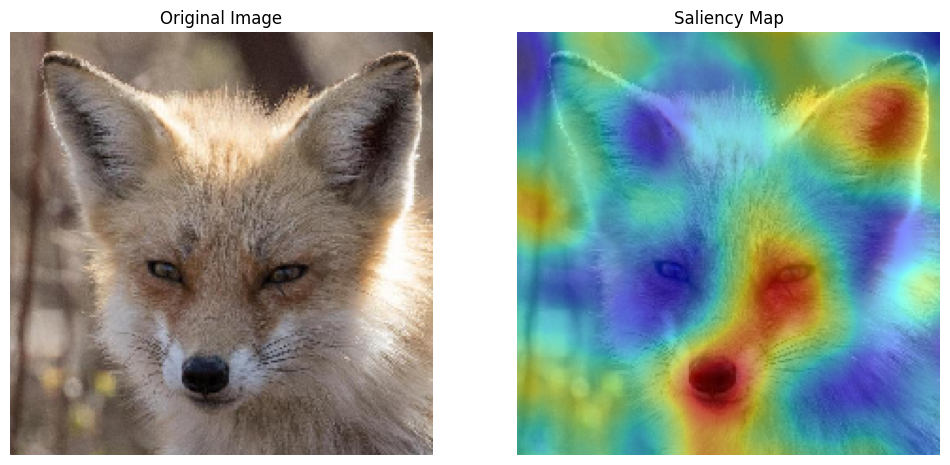

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script
# Initialize model
model = Model().to(device)

# Load image and preprocess
img, x = load_img('/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000257.jpg', model)

# Generate RISE masks
masks = generate_masks(2000, 8, 0.5, model.input_size)

# Apply RISE for saliency maps
sal = explain(model, x, masks, 2000, 32, 0.5)

# Convert saliency map to correct format for display
sal = np.squeeze(sal)  # Remove single-dimensional entries from the shape
sal = np.clip(sal, 0, 1)  # Ensure sal is within the range [0, 1] for display

# Plotting
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 2, 2)
plt.imshow(img)  # Display original image as background
plt.imshow(sal, cmap='jet', alpha=0.5)  # Overlay saliency map
plt.title('Saliency Map')
plt.axis('off')

plt.show()

# **Helper functions**

In [ ]:
def explain_RISE_AD(model, inp, masks, N, batch_size, p1):
    model.eval()
    preds = []

    # Convert input to tensor and ensure it is on the correct device
    inp = torch.tensor(np.copy(inp), dtype=torch.float32).to(device)  # inp: (N, 3, 224, 224)

    # Ensure masks has the right dimensions and squeeze the last dimension
    masks = torch.tensor(np.copy(masks), dtype=torch.float32).unsqueeze(1).to(device)  # masks: (N, 1, 224, 224, 1)
    masks = masks.squeeze(-1)  # Remove the last dimension: (N, 1, 224, 224)

    # Print shape for debugging
#     print("Masks shape before repeat:", masks.shape)

    # Repeat to create 3 channels (N, 3, 224, 224)
    masks = masks.repeat(1, 3, 1, 1)
#     print("Masks shape after repeat:", masks.shape)

    # Multiply the input by the masks (apply the mask to each channel of the input)
    masked = inp * masks  # masked: (N, 3, 224, 224)

    with torch.no_grad():
        for i in range(0, N, batch_size):
            # Get a batch of masked images
            batch = masked[i:min(i + batch_size, N)]  # batch: (batch_size, 3, 224, 224)

            # Forward pass through the model
            preds_batch = model(batch).cpu().numpy()
            preds.append(preds_batch)

    preds = np.concatenate(preds)  # preds: (N, num_classes)

    # Calculate the saliency map by combining predictions with the masks
    masks_np = masks.cpu().numpy()
    sal = preds.T.dot(masks_np.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1

    # Average the saliency map over the channels
    if sal.ndim == 4:
        sal = np.mean(sal, axis=0)  # Average across channels
    elif sal.ndim == 3:
        sal = np.mean(sal, axis=0)  # Handle 3D case if needed

    return sal


In [ ]:
def get_center_attack_matrix(x, y, r, org_expl, L):
    """
    Generates a center attack matrix based on the explanation map.

    Parameters:
        x (int): x-coordinate of the center.
        y (int): y-coordinate of the center.
        r (int): Radius for the attack.
        org_expl (torch.Tensor): Explanation map.
        L (int): Size of the matrix.

    Returns:
        np.ndarray: Attack matrix.
    """
    exp_list = org_expl.flatten().cpu().numpy()  # Convert to numpy for processing
    exp_list_sort_idx = np.argsort(exp_list)[::-1]  # Indices of sorted explanations
    exp_list_sort = exp_list[exp_list_sort_idx]  # Sorted explanations
    mtx = np.zeros((L, L))

    # Initialize dictionaries
    counter_dict = defaultdict(int)
    counter_dict_sum = defaultdict(int)

    # Compute distance-based counts
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            counter_dict[n1] += 1

    # Compute cumulative counts
    max_n1 = max(x - 1 + y - 1, y + L - x - 1, L - x + L - y, L - y - 1 + x)
    for i in range(max_n1):
        if i == 0:
            counter_dict_sum[i] = 1
        else:
            counter_dict_sum[i] = counter_dict[i] + counter_dict_sum[i - 1]

    # Fill the matrix
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            idx = counter_dict_sum.get(n1 - 1, 0)
            if idx >= len(exp_list_sort):
                idx = len(exp_list_sort) - 1  # Cap index to the maximum available index

            if n1 == 0:
                mtx[i, j] = exp_list_sort[0]
            elif n1 == 1:
                mtx[i, j] = exp_list_sort[1]
            elif n1 < r:
                mtx[i, j] = exp_list_sort[idx]
            else:
                mtx[i, j] = -exp_list_sort[min(len(exp_list_sort) - 1, counter_dict_sum.get(max_n1 + 1, 0))]

    return mtx

# **Adversarial attack function using RISE**

In [ ]:
# Adversarial attack function using RISE for explanation
def get_expl(model, x, N=2000, s=8, p1=0.5, batch_size=32):
    """
    Helper method to get the heatmap using RISE with a PyTorch model.
    """
    x = x.to(device)  # Ensure x is on the correct device
    x.requires_grad = True

    # Generate masks
    masks = generate_masks(N, s, p1, model.input_size)

    # Apply RISE to obtain the explanation map
    heatmap = explain_RISE_AD(model, x.cpu().detach().numpy(), masks, N, batch_size, p1)

    # Normalize the heatmap
    normalized_heatmap = heatmap / np.sum(heatmap)

    preds = model(x)
    desired_index = preds.argmax().item()

    return normalized_heatmap, preds, desired_index


In [ ]:
from torchvision import transforms
from PIL import Image
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the image path
image_path = '/kaggle/input/animal-faces/afhq/train/wild/flickr_wild_000031.jpg'

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')

# Define the preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])

# Apply transformations to the image
img_tensor = preprocess(image)

# Add a batch dimension
img_tensor = img_tensor.unsqueeze(0)

# Move to device
img_tensor = img_tensor.to(device)

# Ensure the model is on the same device as the input tensor
model = model.to(device)

# Make predictions
predictions = model(img_tensor)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))  # Should print the class index
origin_prediction_class = prediction_class

# Convert the image to a numpy array for further processing
im2 = np.array(image)
im2 = im2.astype(np.float64)
im_orig = im2  # Now im_orig has the shape (224, 224, 3)
print('im2.shape:', im2.shape)

# Further processing
im = im_orig.astype(np.float32)
print('im:', im.shape, type(im))  # Should print the shape of the image, e.g., (224, 224, 3)
print('ori_image')

# Sorting the prediction values
value_sort = np.sort(predictions[0])[::-1]
print(value_sort[:2][0], value_sort[:2][1])
score_diff = value_sort[:2][0] - value_sort[:2][1]
print('dump score diff:', score_diff)

Prediction class: 277
im2.shape: (512, 512, 3)
im: (512, 512, 3) <class 'numpy.ndarray'>
ori_image
6.8667636 4.799742
dump score diff: 2.0670214


In [ ]:
preprocess_1 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),          # Convert image to tensor
])

#without normalization
img_tensor_1 = preprocess_1(image)
# Move to device (GPU or CPU)
img_tensor_1 = img_tensor_1.to(device)

img_tensor_1 = img_tensor_1.unsqueeze(0)

In [ ]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  277  score:  6.8667636
label:  278  score:  4.799742
label:  280  score:  4.5967574
label:  274  score:  2.7414289
label:  273  score:  2.4662988


Iteration 1: Total Loss: 1.0336783512476799e-10, Center Loss: 1.0336783873299282e-08, Output Loss: 0.0
Iteration 50: Total Loss: 0.0001481717190472409, Center Loss: 1.2924478376419302e-08, Output Loss: 0.1481715738773346
Iteration 100: Total Loss: 0.0001481717190472409, Center Loss: 1.2676689031820843e-08, Output Loss: 0.1481715738773346


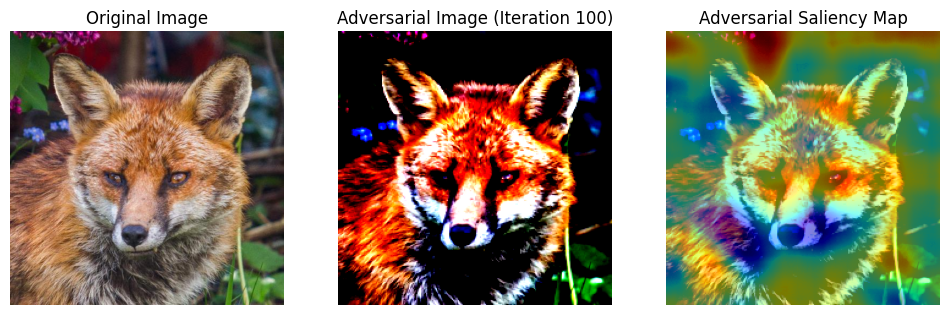

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_iter = 100  # Number of iterations for the attack
prefactors = [0.01, 0.001]  # Weights for the loss terms
early_stop_epoch = 0
EARLY_STOP = True
learning_rate = 1e-4  # Learning rate for perturbations

# Initialize optimizer
x_adv = img_tensor.clone().detach().to(device).requires_grad_(True)
optimizer = torch.optim.Adam([x_adv], lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# Instantiate the loss function
mse_loss = nn.MSELoss()

# Store results
total_loss_list = []
epoch_exp = []
L1_score = []
L2_score = []
L3_score = []
L4_score = []
L5_score = []

# Original prediction
output = model(img_tensor)
origin_prediction_class = output.argmax().item()

# Explanation for the original image using RISE
org_masks = generate_masks(2000, 8, 0.5, model.input_size)
org_expl = explain_RISE_AD(model, img_tensor.cpu().detach().numpy(), org_masks, 2000, 32, 0.5)
org_expl_torch = torch.tensor(org_expl).to(device).float()  # Convert to tensor for further use

# Debug: Check the shape of the explanation tensor
# print("org_expl_torch shape:", org_expl_torch.shape)  # Should now be [224, 224]

# Define center coordinates and radius for the attack (assuming the explanation map is 224x224)
x_center = org_expl_torch.shape[0] // 2  # Center of the image (height // 2)
y_center = org_expl_torch.shape[1] // 2  # Center of the image (width // 2)
r_attack = 10  # Define radius for the attack
L = org_expl_torch.shape[0]  # Assuming L is the size of the matrix (height)

# Ensure target matrix is created using get_center_attack_matrix()
target_mtx = get_center_attack_matrix(x_center, y_center, r_attack, org_expl_torch, L)
target_mtx_torch = torch.tensor(target_mtx, requires_grad=True).to(device).float()

# Check shape compatibility
if target_mtx_torch.shape != org_expl_torch.shape:
    target_mtx_torch = target_mtx_torch.view_as(org_expl_torch)

org_acc = output.clone().detach()

# Define attack and explanation loop
for i in range(num_iter):
    optimizer.zero_grad()  # Reset gradients

    # Forward pass for the adversarial image
    adv_output = model(x_adv)

    # Compute adversarial accuracy for the output
    adv_acc = adv_output.clone().detach()

    # Compute explanation for the adversarial image using RISE
    adv_masks = generate_masks(2000, 8, 0.5, model.input_size)
    adv_expl = explain_RISE_AD(model, x_adv.detach().cpu().numpy(), adv_masks, 2000, 32, 0.5)
    adv_expl_torch = torch.tensor(adv_expl).to(device).float()

    # Ensure target matrix has matching shape
    if target_mtx_torch.shape != adv_expl_torch.shape:
        target_mtx_torch = target_mtx_torch.view_as(adv_expl_torch)

    # Loss 1: MSE between the explanation maps (i.e., attacking the explanation)
    L1 = mse_loss(adv_expl_torch, target_mtx_torch)

    # Loss 2: Difference between original and adversarial outputs (to minimize classification accuracy)
    L2 = mse_loss(adv_acc[0][origin_prediction_class], org_acc[0][origin_prediction_class].detach())

    # Weighted sum of losses
    total_loss = prefactors[0] * L1 + prefactors[1] * L2
    total_loss_list.append(total_loss.item())

    # Backpropagation
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Obtain new predictions
    predictions = model(x_adv)
    predictions = predictions.cpu().detach().numpy()

    # Update scores for top-5 classes
    index_sort = np.argsort(predictions[0])[::-1]
    L1_score.append(predictions[0][index_sort[0]])
    L2_score.append(predictions[0][index_sort[1]])
    L3_score.append(predictions[0][index_sort[2]])
    L4_score.append(predictions[0][index_sort[3]])
    L5_score.append(predictions[0][index_sort[4]])

    # Early stopping condition
    prediction_class_tmp = np.argmax(predictions[0])
    if i > 10 and origin_prediction_class != prediction_class_tmp:
        print(i, 'early done')
        early_stop_epoch = i
        if EARLY_STOP:
            x_adv = x_adv.clone().detach()
            break

    # Clamp the adversarial example
    x_adv.data = torch.clamp(x_adv.data, 0, 1)  # Ensure valid range [0, 1]

    # Update the adversarial saliency
    epoch_exp.append(adv_expl)

    # Debugging information
    if (i + 1) % 50 == 0 or i == 0:
        print(f"Iteration {i + 1}: Total Loss: {total_loss.item()}, Center Loss: {L1.item()}, Output Loss: {L2.item()}")

# Final adversarial example
adv_image_np = x_adv.detach().cpu().numpy().squeeze()  # Convert to NumPy array
adv_image_np = np.transpose(adv_image_np, (1, 2, 0))  # Convert back to (H, W, C)
adv_image_np = np.clip(adv_image_np * 255, 0, 255).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8

# Plot results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Adversarial Image
plt.subplot(1, 3, 2)
plt.imshow(adv_image_np)
plt.title(f"Adversarial Image (Iteration {early_stop_epoch if early_stop_epoch else num_iter})")
plt.axis("off")

# Saliency Map for Adversarial Image
adv_expl_np = adv_expl_torch.detach().cpu().numpy()
plt.subplot(1, 3, 3)
plt.imshow(adv_image_np)  # Display adversarial image as background
plt.imshow(adv_expl_np, cmap='jet', alpha=0.5)  # Overlay RISE saliency map
plt.title("Adversarial Saliency Map")
plt.axis("off")

plt.show()

In [ ]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  277  score:  6.481833
label:  280  score:  5.3956976
label:  278  score:  4.8167214
label:  271  score:  4.020878
label:  272  score:  3.9424636
